In [1]:
import sys

sys.path.insert(1, 'C:/Users/peter/Desktop/volatility-forecasting/midas')

from weights import Beta
from base import BaseModel
from helper_functions import create_matrix
from stats import loglikelihood_normal
from volatility import Panel_GARCH, Panel_GARCH_CSA, Panel_MIDAS, Panel_GARCH_MIDAS, MGARCH
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
import time
from pandas.tseries.offsets import BDay

%matplotlib inline

plt.style.use('bmh')

## Forecasting

The conditional variance of a GARCH(1, 1) process can be forecasted for the t + $\tau$ with $\tau > 0$. First, for the one step ahead forecast:

$\sigma_{t + 1 | t}^2 = E[\epsilon_{t + 1}^2 | \mathcal{F}_t] = \alpha_0 + \alpha \epsilon_t + \beta \sigma_t^2$

For $\tau = 2$ we get

$\sigma_{t + 2 | t}^2 = E[\epsilon_{t + 2}^2 | \mathcal{F}_t] = \alpha_0 + (\alpha + \beta) E[\epsilon_{t + 1}^2 | \mathcal{F}_t] = \\
= \alpha_0 + (\alpha + \beta) \sigma_{t + 1 | t}^2$

Iteration leads us to:

$\sigma_{t + \tau | t}^2 = \alpha_0 \frac{1 - (\alpha + \beta)^{\tau - 1}}{1 - \alpha - \beta} + (\alpha + \beta)^{\tau - 1} \sigma_{t + 1 | t}^2 $

As we increase the forecast horizon above all limits, we have

$\lim_{\tau\to\infty} \sigma_{t + \tau | t}^2 = \frac{\alpha0}{1 - \alpha - \beta} = V[\epsilon_t]$

As we use our simplification, that said we can estimate unconditional variance by the mean of squared returns, we can rewrite these equations for the following:

$\sigma_{t + \tau | t}^2 = \hat{\mu} (1 - (\alpha + \beta)^{\tau - 1}) + (\alpha + \beta)^{\tau - 1} \sigma_{t + 1 | t}^2 $


In [65]:
def forecast(params, y, sigma2, tau = None, H = 5):
    """
    Parameters:
    params: List of Parameters
    y:      Series or Array of Returns
    sigma2: Series or Array of (Short-term) Volatility
    tau:    Series or Array of Long-term Volatility component
    H:      Forecast Horizon

    Return:
    forecasted_series:   Series or Array that contain the past Volatilities and the forecasted ones.
                         If y is a series, the function will create dates by BDay function.
    """
    from pandas.tseries.offsets import BDay
    forecast = np.zeros(H)
    mu = np.mean(y ** 2)
    alpha = params[0]
    beta = params[1]
    
    if isinstance(tau, np.ndarray) or isinstance(tau, list):
        tau_t = tau[-1]
    elif isinstance(tau, int) or isinstance(tau, float):
        tau_t = tau
    elif tau is None:
        pass
    else:
        raise ValueError("ValueError exception thrown")

    for t in range(1, H + 1):
        if tau is None:
            forecast[t - 1] = mu * (1 - (alpha + beta) ** (t - 1)) + (alpha + beta) ** (t - 1) * sigma2[-1] 
        else:
            forecast[t - 1] = mu * (1 - (alpha + beta) ** (t - 1)) + (alpha + beta) ** (t - 1) * sigma2[-1] * tau_t

    forc = np.zeros(len(y) + H)
    if tau is None:
        forc[:-H] = sigma2
    elif isinstance(tau, np.ndarray) or isinstance(tau, list):
        forc[:-H] = sigma2 * tau
    forc[-H:] = forecast

    if isinstance(y, pd.core.series.Series) or isinstance(y, pd.core.frame.DataFrame):
        index = []
        for i in range(len(y) + H):
            if i < len(y):
                index.append(y.index[i])
            else:
                index.append(y.index[-1] + BDay(i - len(y.index) + 1))

        forecasted_series = pd.Series(data = forc, index = index)
    else:
        forecasted_series = forc

    return forecasted_series

In [84]:
def forecast(params, y, sigma2, H = 5):
    """
    Parameters:
    params: List of Parameters
    y:      Series or Array of Returns
    sigma2: Series or Array of (Short-term) Volatility
    H:      Forecast Horizon

    Return:
    forecasted_series:   Series or Array that contain the past Volatilities and the forecasted ones.
                         If y is a series, the function will create dates by BDay function.
    """
    from pandas.tseries.offsets import BDay
    forecast = np.zeros(H)
    mu = np.mean(y ** 2)
    alpha = params[0]
    beta = params[1]
    
    for t in range(1, H + 1):
        forecast[t - 1] = mu * (1 - (alpha + beta) ** (t - 1)) + (alpha + beta) ** (t - 1) * sigma2[-1]
    
    forc = np.zeros(len(y) + H)
    forc[:-H] = sigma2
    forc[-H:] = forecast
    
    if isinstance(y, pd.core.series.Series) or isinstance(y, pd.core.frame.DataFrame):
        index = []
        for i in range(len(y) + H):
            if i < len(y):
                index.append(y.index[i])
            else:
                index.append(y.index[-1] + BDay(i - len(y.index) + 1))

        forecasted_series = pd.Series(data = forc, index = index)
    else:
        forecasted_series = forc

    return forecasted_series

In [44]:
data = pd.read_csv('C:/Users/peter/Desktop/volatility-forecasting/results/Data_matrix.csv')

In [45]:
data.set_index(pd.to_datetime(data.iloc[:, 0]), inplace = True)

In [46]:
data = data.iloc[:, 1:]

In [47]:
data

,VIX,NFCI,CFNAI,IP_delta,HOUST_delta,DTB3,soyc,BAA10Y,Inflation,UNRATE,PPI_delta,M2_delta,csh_delta
Unnamed: 0,,,,,,,,,,,,,
1997-01-01,0.174745,0.019374,0.759392,0.703762,0.527331,0.795316,0.454905,0.030121,0.633140,0.159292,0.685185,0.131356,0.543170
1997-02-01,0.180529,0.032841,0.781764,0.748648,0.762058,0.815259,0.491349,0.014679,0.633140,0.150442,0.574074,0.114382,0.547130
1997-03-01,0.191184,0.014855,0.760236,0.726292,0.504823,0.810710,0.460179,0.015609,0.602568,0.150442,0.574074,0.126645,0.585046
1997-04-01,0.192991,0.014942,0.750950,0.698819,0.607717,0.833145,0.492596,0.007328,0.602568,0.141593,0.629630,0.130667,0.599360
1997-05-01,0.182950,0.031728,0.756437,0.722881,0.471061,0.836111,0.533511,0.000000,0.587282,0.123894,0.672840,0.115805,0.619918
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-07-01,0.402741,0.139078,0.861967,0.913991,0.908360,0.024043,0.260062,0.320762,0.789361,0.592920,0.759259,0.184952,0.805086
2020-08-01,0.321353,0.123777,0.795272,0.749396,0.368167,0.018731,0.242938,0.273412,0.725925,0.433628,0.728395,0.120404,0.914421
2020-09-01,0.244860,0.082421,0.767412,0.693303,0.654341,0.015073,0.254523,0.257370,0.684806,0.380531,0.722222,0.250687,0.955992


In [48]:
ret_matrix = pd.read_csv('C:/Users/peter/Desktop/volatility-forecasting/results/ret_matrix.csv')
ret_matrix.set_index(pd.to_datetime(ret_matrix.Date), inplace = True)
ret_matrix = ret_matrix.iloc[:, 1:] * 100

In [49]:
ret_matrix.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5272 entries, 1999-11-18 to 2020-10-30
Columns: 493 entries, A to ZTS
dtypes: float64(493)
memory usage: 19.9 MB


In [50]:
ret_mat = ret_matrix.iloc[1:, :]
nan_cols = np.where(ret_mat.isna().sum().values == 1)[0]
nan_index = np.where(ret_mat.iloc[:, nan_cols].isna() == True)[0]
print(set(nan_index))

{455}


In [51]:
if len(set(nan_index)) == 1.0:
    ret_mat = ret_mat.drop([ret_mat.index[nan_index[0]]])

In [52]:
print(np.where(ret_mat.isna().sum().values == 1)[0])

[]


In [53]:
X = data[(data.index >= datetime(1999,12,1)) & (data.index <= datetime(2007,12,1))].iloc[:, :6]
X

,VIX,NFCI,CFNAI,IP_delta,HOUST_delta,DTB3
Unnamed: 0,,,,,,
1999-12-01,0.222948,0.165637,0.772478,0.735831,0.647910,0.821214
2000-01-01,0.229981,0.161220,0.757282,0.698682,0.435691,0.841645
2000-02-01,0.247619,0.156043,0.737864,0.712548,0.713826,0.861471
2000-03-01,0.260600,0.152763,0.766146,0.715833,0.337621,0.898725
2000-04-01,0.241574,0.176774,0.768257,0.733757,0.586817,0.922551
...,...,...,...,...,...,...
2007-08-01,0.135070,0.095325,0.745040,0.710074,0.512862,0.780784
2007-09-01,0.285847,0.231017,0.747995,0.719159,0.315113,0.680193
2007-10-01,0.232745,0.282579,0.734909,0.674442,0.681672,0.629931


In [54]:
y = ret_mat[(ret_mat.index >= X.index[0]) & (ret_mat.index < X.index[-1])]
y

,A,AAL,AAP,AAPL,ABBV,ABC,ABMD,ABT,ACN,ADBE,...,XLNX,XOM,XRAY,XRX,XYL,YUM,ZBH,ZBRA,ZION,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
1999-12-01,1.762178,NaN,NaN,5.164480,NaN,0.503771,-0.405680,-1.491311,NaN,-3.142563,...,-0.069810,3.940294,-2.110971,-2.515317,NaN,-1.977239,NaN,-1.459874,1.154995,NaN
1999-12-02,2.728095,NaN,NaN,6.684766,NaN,-2.544623,0.809721,0.374895,NaN,3.051530,...,5.638132,-0.512683,-2.156383,-0.947849,NaN,-1.081107,NaN,-3.419138,0.857531,NaN
1999-12-03,0.846262,NaN,NaN,4.274904,NaN,-3.141606,-1.421344,-0.374895,NaN,-2.863924,...,-6.974775,0.550482,4.005884,-1.197612,NaN,-0.623022,NaN,1.510278,2.529405,NaN
1999-12-06,2.770258,NaN,NaN,0.865724,NaN,1.583089,0.000000,-2.879155,NaN,-5.490060,...,3.068556,1.615089,-3.462417,0.480733,NaN,0.156091,NaN,-1.401646,-2.529405,NaN
1999-12-07,-1.098914,NaN,NaN,1.550422,NaN,-1.052634,0.611623,-1.558476,NaN,-4.040944,...,-2.433231,0.000000,0.540565,-2.181862,NaN,0.466931,NaN,-3.199382,-3.475206,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2007-11-26,-1.007479,-4.010538,-2.573713,0.581229,NaN,-0.594154,-3.448618,-2.259952,-3.708414,-2.439436,...,-2.473844,-3.000757,-1.756896,-2.136196,NaN,-2.012080,-1.278465,-0.190450,-5.636672,NaN
2007-11-27,0.790522,-0.204837,0.149694,1.307064,NaN,-1.059911,-0.083579,3.014006,-0.295612,0.414782,...,2.196840,0.813648,3.338566,0.553688,NaN,-0.108501,1.340416,1.781423,1.994231,NaN
2007-11-28,2.995678,7.216566,2.190079,3.047881,NaN,2.876898,3.774033,0.908042,3.118447,2.310570,...,2.194874,1.767099,2.031360,3.555666,NaN,0.891313,1.230980,1.566058,5.017540,NaN


In [55]:
pgm = Panel_GARCH_MIDAS()

In [56]:
rest_midas = ['pos'] + ['pos', 'pos'] * X.shape[1]
rest_garch = ['01', '01']
pgm.fit(rest_midas, rest_garch, X, y)

Estimated parameters for the MIDAS equation:



C:/Users/peter/Desktop/volatility-forecasting/midas\weights.py:25: RuntimeWarning: invalid value encountered in true_divide
  beta_vals = b.pdf(x, params[0], params[1]) / np.sum(b.pdf(x, params[0], params[1]))
C:/Users/peter/Desktop/volatility-forecasting/midas\base.py:34: RuntimeWarning: overflow encountered in exp
  params[i] = np.exp(params_trans[i])
C:\Users\peter\anaconda3\lib\site-packages\scipy\stats\_continuous_distns.py:598: RuntimeWarning: invalid value encountered in subtract
  lPx -= sc.betaln(a, b)
C:/Users/peter/Desktop/volatility-forecasting/midas\base.py:47: RuntimeWarning: overflow encountered in exp
  g[i] = np.exp(param_trans[i])


Loglikelihood:  1013.486017088585 

      Parameters  Standard Error  95% CI Lower  95% CI Higher
0   2.219235e+00    2.036950e-01  1.820000e+00   2.618470e+00
1   8.415620e+00    3.549988e+02 -6.873693e+02   7.042006e+02
2   1.967969e+05             inf          -inf            inf
3   3.428424e+01    3.257911e+13 -6.385388e+13   6.385388e+13
4   8.317054e+00    4.322739e+02 -8.389243e+02   8.555584e+02
5   2.407811e-06    1.015347e-01 -1.990020e-01   1.990068e-01
6   1.365482e+04             inf          -inf            inf
7   3.899842e-06    1.015344e-01 -1.989998e-01   1.990076e-01
8   9.005414e+03             inf          -inf            inf
9   2.108019e-05    1.015374e-01 -1.989887e-01   1.990308e-01
10  2.058422e+03             inf          -inf            inf
11  1.360010e-08    1.015346e-01 -1.990042e-01   1.990042e-01
12  1.797052e+04             inf          -inf            inf

Estimated parameters for the GARCH equation:

Loglikelihood:  546.5574125074513 

   Parameters

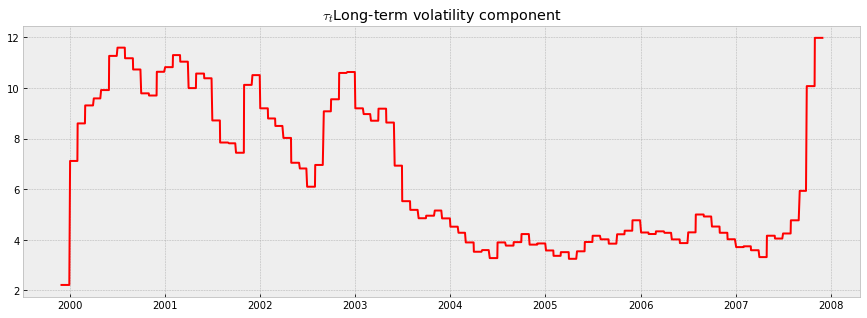

In [57]:
plt.figure(figsize = (15, 5))
plt.plot(y.index, pgm.midas.tau_t, 'r')
plt.title(r'$\tau_t$'+'Long-term volatility component')
plt.grid(True)
plt.show()

In [58]:
xom = y['XOM'] / pgm.midas.tau_t
xom_vola = pgm.garch.model_filter(pgm.garch.optimized_params, xom)

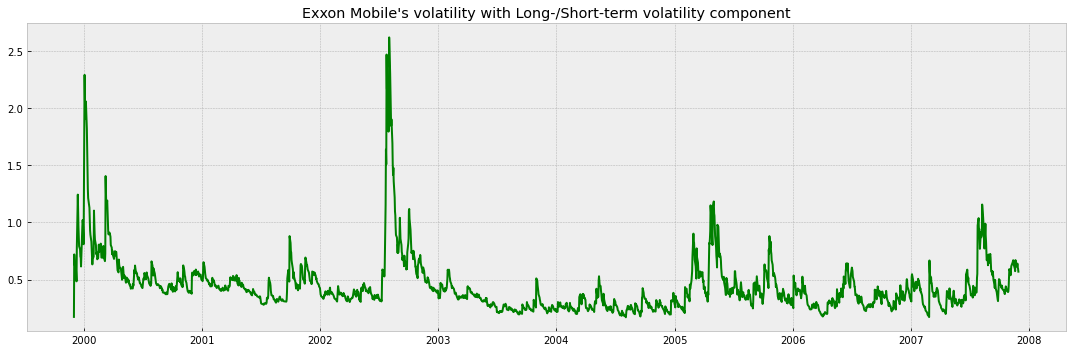

In [59]:
plt.figure(figsize = (15, 5))
plt.plot(xom.index, xom_vola * pgm.midas.tau_t, 'g')
plt.title("Exxon Mobile's volatility with Long-/Short-term volatility component")
plt.grid(True)
plt.tight_layout()
plt.show()

In [82]:
xom_forc = forecast(pgm.garch.optimized_params, xom, xom_vola, tau = pgm.midas.tau_t, H = 22)

TypeError: 'numpy.ndarray' object is not callable

In [64]:
xom_forc[-30:]

2007-11-20    0.574151
2007-11-21    0.670749
2007-11-23    0.635542
2007-11-26    0.613176
2007-11-27    0.640332
2007-11-28    0.608174
2007-11-29    0.596641
2007-11-30    0.569575
2007-12-03    0.569575
2007-12-04    0.545254
2007-12-05    0.522137
2007-12-06    0.500164
2007-12-07    0.479279
2007-12-10    0.459428
2007-12-11    0.440559
2007-12-12    0.422625
2007-12-13    0.405578
2007-12-14    0.389376
2007-12-17    0.373975
2007-12-18    0.359337
2007-12-19    0.345423
2007-12-20    0.332198
2007-12-21    0.319628
2007-12-24    0.307680
2007-12-25    0.296324
2007-12-26    0.285529
2007-12-27    0.275269
2007-12-28    0.265517
2007-12-31    0.256248
2008-01-01    0.247438
dtype: float64

In [66]:
mu = np.mean(xom ** 2)
alpha, beta = pgm.garch.optimized_params

In [67]:
H = 22
forecast = np.zeros(H)

for i in range(1, H + 1):
    forecast[i - 1] = (mu * (1 - (alpha + beta) ** (i - 1)) + xom_vola[-1] * (alpha + beta) ** (i - 1)) * pgm.midas.tau_t[-1]

In [68]:
index = []
for i in range(len(y.index) + H):
    if i < len(y.index):
        index.append(y.index[i])
    else:
        index.append(y.index[-1] + BDay(i - len(y.index) + 1))

In [69]:
sima = np.zeros(len(xom_vola) + H)
sima[-H:] = forecast
vola = np.zeros(len(xom_vola) + H)
vola[:-H] = xom_vola * pgm.midas.tau_t

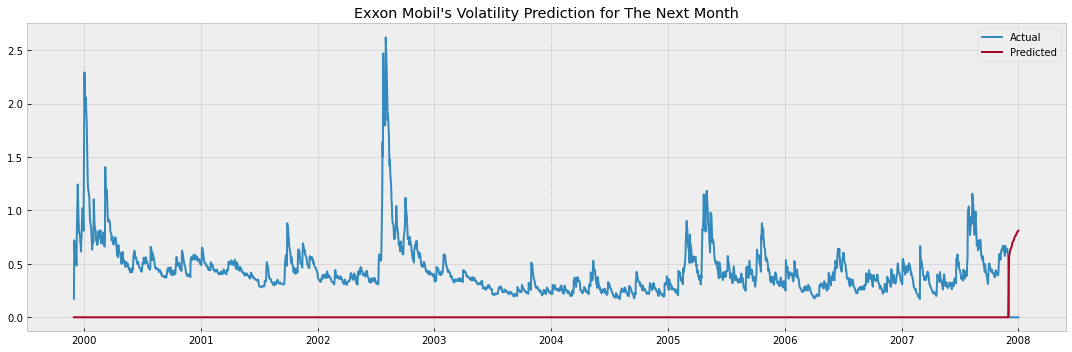

In [70]:
plt.figure(figsize = (15, 5))
plt.plot(index, vola, label = 'Actual')
plt.plot(index, sima, label = 'Predicted')
plt.title("Exxon Mobil's Volatility Prediction for The Next Month")
plt.legend(loc = 'best')
plt.grid(True)
plt.tight_layout()
plt.show()

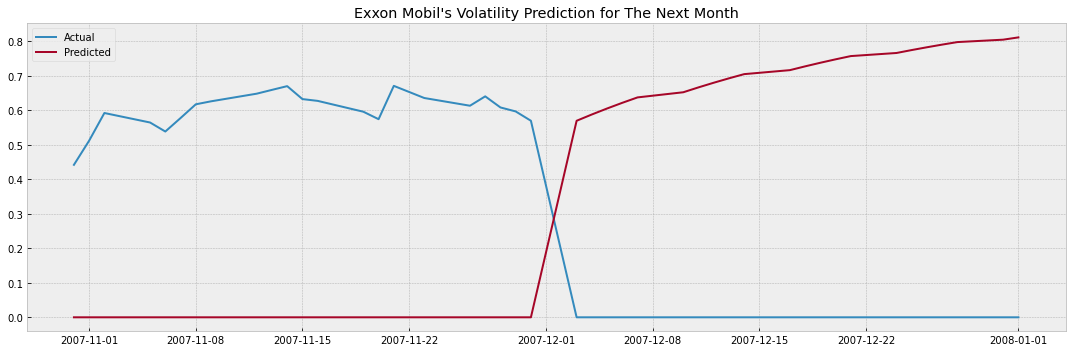

In [71]:
plt.figure(figsize = (15, 5))
plt.plot(index[-22 - H:], vola[-22 - H:], label = 'Actual')
plt.plot(index[-22 - H:], sima[-22 - H:], label = 'Predicted')
plt.title("Exxon Mobil's Volatility Prediction for The Next Month")
plt.legend(loc = 'best')
plt.grid(True)
plt.tight_layout()
plt.show()

In [24]:
mgarch = MGARCH(lag = 12, plot = True)

In [46]:
rest = ['01', '01', 'pos'] + ['pos', 'pos'] * X.shape[1]
mgarch.fit(rest, X.iloc[:, :1], y.XOM)

Loglikelihood:  1.7664861255514452 

   Parameters  Standard Error  95% CI Lower  95% CI Higher
0    0.061027        0.105543     -0.145834       0.267889
1    0.927465        0.060777      0.808345       1.046585
2    1.145214        4.182853     -7.053027       9.343455
3    0.005072        0.436813     -0.851066       0.861211
4    3.363829       68.038440   -129.989062     136.716721


In [47]:
XOM_volat = mgarch.predict(X.iloc[:, :1], y.XOM)

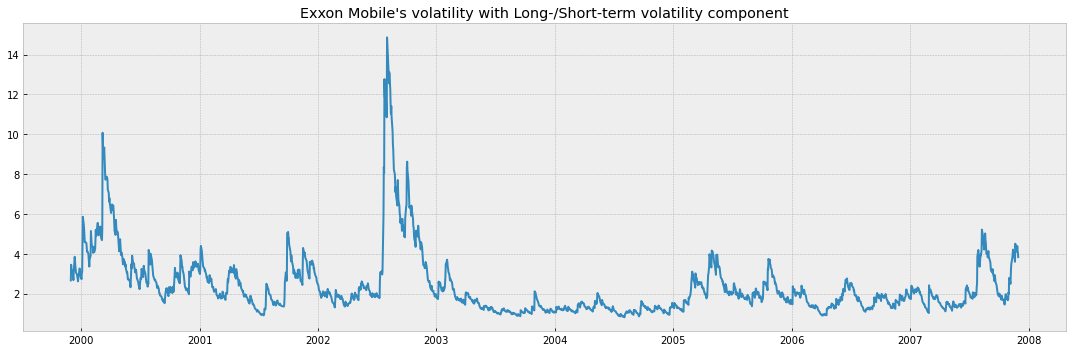

In [48]:
plt.figure(figsize = (15, 5))
plt.plot(y.XOM.index, XOM_volat)
plt.title("Exxon Mobile's volatility with Long-/Short-term volatility component")
plt.grid(True)
plt.tight_layout()
plt.show()

In [40]:
a, b = mgarch.optimized_params[:2]

In [41]:
H = 22
frct = np.zeros(H)

for i in range(1, H + 1):
    frct[i - 1] = (mu * (1 - (a + b) ** (i - 1)) + XOM_volat[-1] * (a + b) ** (i - 1)) * mgarch.tau[-2]

In [42]:
forc = np.zeros(len(XOM_volat) + H)
forc[-H:] = frct
volat = np.zeros(len(XOM_volat) + H)
volat[:-H] = XOM_volat

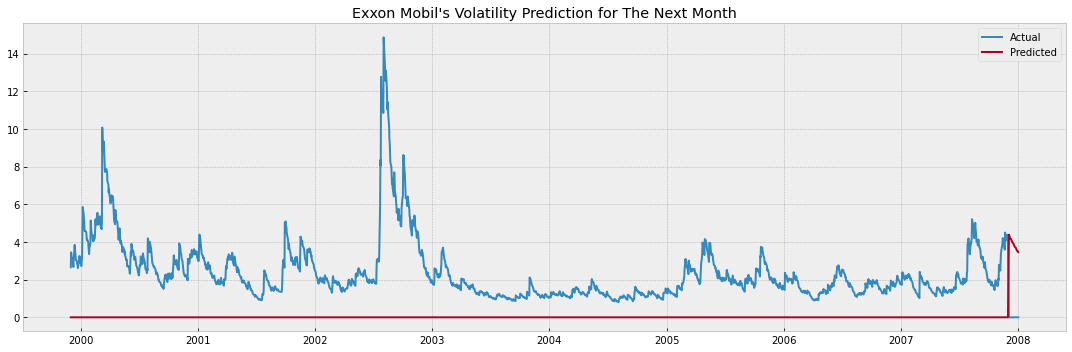

In [43]:
plt.figure(figsize = (15, 5))
plt.plot(index, volat, label = 'Actual')
plt.plot(index, forc, label = 'Predicted')
plt.title("Exxon Mobil's Volatility Prediction for The Next Month")
plt.legend(loc = 'best')
plt.grid(True)
plt.tight_layout()
plt.show()

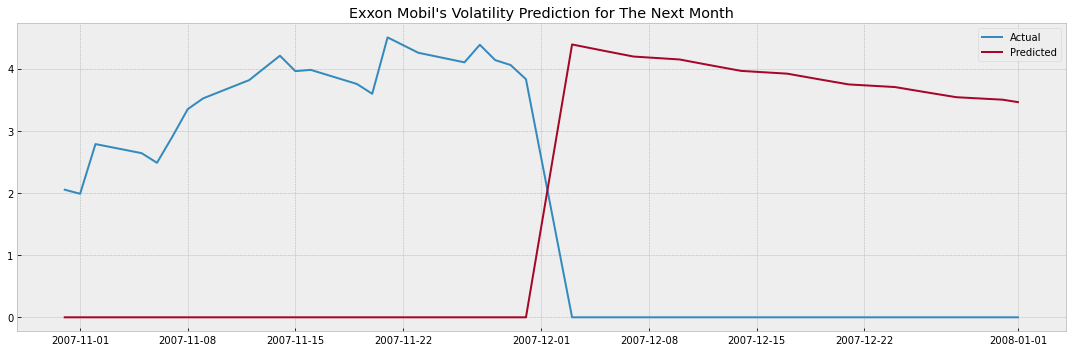

In [44]:
plt.figure(figsize = (15, 5))
plt.plot(index[-22 - H:], volat[-22 - H:], label = 'Actual')
plt.plot(index[-22 - H:], forc[-22 - H:], label = 'Predicted')
plt.title("Exxon Mobil's Volatility Prediction for The Next Month")
plt.legend(loc = 'best')
plt.grid(True)
plt.tight_layout()
plt.show()

In [88]:
from volatility import Panel_GARCH

In [89]:
panel_garch = Panel_GARCH()

In [90]:
panel_garch.fit(['01', '01'], y)

C:/Users/peter/Desktop/volatility-forecasting/midas\stats.py:35: RuntimeWarning: invalid value encountered in log
  lls = -0.5 * (np.log(2*np.pi) + np.log(sigma2) + resid ** 2 / sigma2)
C:/Users/peter/Desktop/volatility-forecasting/midas\stats.py:35: RuntimeWarning: divide by zero encountered in log
  lls = -0.5 * (np.log(2*np.pi) + np.log(sigma2) + resid ** 2 / sigma2)
C:/Users/peter/Desktop/volatility-forecasting/midas\stats.py:35: RuntimeWarning: divide by zero encountered in true_divide
  lls = -0.5 * (np.log(2*np.pi) + np.log(sigma2) + resid ** 2 / sigma2)
C:/Users/peter/Desktop/volatility-forecasting/midas\stats.py:35: RuntimeWarning: invalid value encountered in add
  lls = -0.5 * (np.log(2*np.pi) + np.log(sigma2) + resid ** 2 / sigma2)
C:/Users/peter/Desktop/volatility-forecasting/midas\stats.py:35: RuntimeWarning: invalid value encountered in true_divide
  lls = -0.5 * (np.log(2*np.pi) + np.log(sigma2) + resid ** 2 / sigma2)


Loglikelihood:  979.6423706192636 

   Parameters  Standard Error  95% CI Lower  95% CI Higher
0     0.00007        0.005575     -0.010857       0.010996
1     1.00000        0.004384      0.991407       1.008593


In [91]:
forc = forecast(pg.optimized_params, y.XOM, pg.model_filter(pg.optimized_params, y.XOM), H = 22)

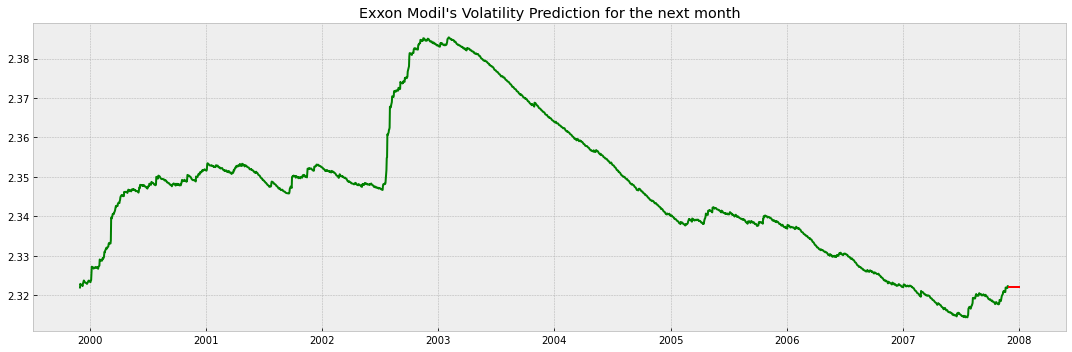

In [108]:
plt.figure(figsize = (15, 5))
plt.plot(forc[forc.index <= pd.to_datetime(y.XOM.index[-1])], 'g')
plt.plot(forc[forc.index > pd.to_datetime(y.XOM.index[-1])], 'r')
plt.title("Exxon Modil's Volatility Prediction for the next month")
plt.tight_layout()
plt.show()

In [107]:
pd.to_datetime(y.XOM.index[-1])

Timestamp('2007-11-30 00:00:00')